In [1]:
path = '../phd-model-process/'

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import scipy as sp
import scipy.stats as st

from helpers_pd import *

# Plotting
import seaborn as sns
sns.set()
# import seaborn as sns; sns.set(style="ticks", color_codes=True)
# sns.set(style="darkgrid")
import matplotlib.pyplot as plt

## Need to separate low and fast flow KGE's!!

In [2]:
gen1x = "Gen10"
df1 = get_data(gen=gen1x)
df1["Gen"] = gen1x
df = pd.concat([df1])
len(df)

4825

In [3]:
# Index names
df['Name'] = df['Gen'] + "/" + df.index
df = df.set_index('Name')

In [4]:
df['k_d'] = df.loc[:, 'k_oc'] * df.loc[:,'f_oc']
df['epsilon_iso'] *= -1
df['dt_50_aged'] = np.log(2)/df['dt_50_aged'] # k_age
df['dt_50_ab'] = np.log(2)/df['dt_50_ab']  # k_irs

In [7]:
dfs = df[['Model', 'Gen',
          'z3_factor',
          'cZ0Z1',
          'cZ',
          'c_adr',
          'k_g',
          'gamma01',
          'gammaZ',
          'f_transp',
          'f_evap',
          'k_d',
          'f_oc',
          'k_oc',
          'beta_runoff',
          'dt_50_aged',
          'dt_50_ab',
          'dt_50_ref',
          'epsilon_iso',
          'beta_moisture',
          'KGE-CONC-tra', 'KGE-d13C-tra',
          'KGE-CONC-blk', 'KGE-d13C-blk',
          'KGE-CONC-det', 'KGE-d13C-det',
          'KGE-Q_out', 
          'KGE-CONC_out', 'KGE-d13C_out',
#           'MAE-CONC_out', 'MAE-d13C_out',
#           'NSE-CONC_out', 'NSE-Q_out',
#           'BIAS-CONC_out', 'BIAS-d13C_out',
#           'BIAS-LDS_out',
#           'BIAS-Q_out'
          ]]
# dfs['KGE-blk'] = (dfs.loc[:, 'KGE-CONC-blk'] + dfs.loc[:,'KGE-d13C-blk'])/2.

In [8]:
gen1x = dfs.loc[(dfs['Gen'] == 'Gen10')]

## Hydrology

In [32]:
blk_b = gen1x.loc[(gen1x['KGE-CONC-blk'] > .0) & (gen1x['KGE-d13C-blk'] >  0.0) & 
                  (gen1x['KGE-Q_out'] >  0.50) &
                  (gen1x['KGE-CONC_out'] >  0.1) &
                  (gen1x['KGE-d13C_out'] >  0.1)
                 ]
len(blk_b)

49

In [33]:
hy_blk = pd.melt(blk_b, 
                 id_vars=['Gen',  'Model', 
                          'KGE-CONC-tra', 'KGE-d13C-tra',
                          'KGE-CONC-blk', 'KGE-d13C-blk',
                          'KGE-CONC-det', 'KGE-d13C-det',
                          'KGE-Q_out'
                         ],
             value_vars=['z3_factor',
                         'cZ0Z1',
                         'cZ',
                         'c_adr',
                         'k_g',
                         'gamma01',
                         'gammaZ',
                         'f_transp',
                         'f_evap'
                         ])

In [34]:
hy_blk.head()

,Gen,Model,KGE-CONC-tra,KGE-d13C-tra,KGE-CONC-blk,KGE-d13C-blk,KGE-CONC-det,KGE-d13C-det,KGE-Q_out,variable,value
0,Gen10,fix,0.142988,0.727835,0.155203,0.708946,0.381189,0.824261,0.537158,z3_factor,0.924822
1,Gen10,fix,0.639382,0.486592,0.042721,0.306700,0.751417,0.612106,0.691033,z3_factor,0.951894
2,Gen10,fix,0.687550,0.785021,0.655199,0.908973,0.788112,0.461953,0.745415,z3_factor,0.975713
3,Gen10,var,0.031989,0.866341,0.068729,0.951704,0.324130,0.703099,0.633722,z3_factor,0.915406
4,Gen10,var,0.029806,0.859192,0.064526,0.957450,0.317426,0.677775,0.738245,z3_factor,0.925989


In [35]:
params = [
    'z3_factor',
    'cZ0Z1',
    'cZ',
    'c_adr',
    'k_g',
    'gamma01',
    'gammaZ',
    'f_transp',
    'f_evap']

means = []
stds = [] # Will be CIs!!
for e in params:
    means.append(hy_blk.loc[hy_blk['variable'] == e].mean()['value'])
    stds.append(hy_blk.loc[hy_blk['variable'] == e].std()['value']*2)
    

In [36]:
bounds_v15 = [[0.85, 0.99],  # z3_factor
              [0.01, 1.], # 'cZ0Z1',
              [0.2, 0.6], # 'cZ'
              [0.01, 1.],  # cadr
              [1500.0, 3650.0],  # k_g
              [0.01, 1.],  # gamma01,
              [0.01, 1.],  # gammaZ
              [0.1, 1.],  # f_transp
              [0.1, 0.9]  # f_evap
             ]

In [37]:
brackets = []
for i in range(len(means)):
    brackets.append((max(round(means[i]-stds[i],3), bounds_v15[i][0]), 
                     min(round(means[i]+stds[i],3), bounds_v15[i][1])))
brackets

[(0.85, 0.99),
 (0.049, 1.0),
 (0.21, 0.6),
 (0.01, 1.0),
 (1500.0, 3650.0),
 (0.017, 0.806),
 (0.01, 1.0),
 (0.221, 1.0),
 (0.1, 0.52)]

In [38]:
# Rename variables
hy_blk.loc[hy_blk['variable'] == 'z3_factor', 'Parameter'] = '$z_f$'
hy_blk.loc[hy_blk['variable'] == 'cZ0Z1', 'Parameter'] = '$c_{z0z1}$'
hy_blk.loc[hy_blk['variable'] == 'cZ', 'Parameter'] = '$c_{z2z3z4}$'
hy_blk.loc[hy_blk['variable'] == 'c_adr', 'Parameter'] = '$c_{adr}$'
hy_blk.loc[hy_blk['variable'] == 'k_g', 'Parameter'] = '$K_{G}$'
hy_blk.loc[hy_blk['variable'] == 'gamma01', 'Parameter'] = '$\gamma_{z0z1}$'
hy_blk.loc[hy_blk['variable'] == 'gammaZ', 'Parameter'] = '$\gamma_{z2z3}$'
hy_blk.loc[hy_blk['variable'] == 'f_transp', 'Parameter'] = '$f_{transp}$'
hy_blk.loc[hy_blk['variable'] == 'f_evap', 'Parameter'] = '$f_{evap}$'

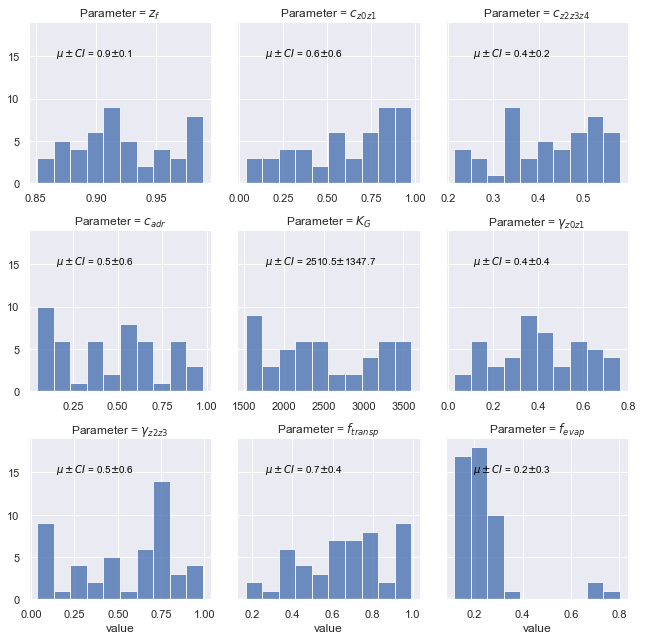

In [39]:
# g = sns.FacetGrid(hy_blk, col="variable", hue="Model", col_wrap=3, sharex=False)
g = sns.FacetGrid(hy_blk, col="Parameter", col_wrap=3, sharex=False)
g = g.map(plt.hist, "value", alpha=.8).add_legend()

counter = 0
for ax in g.axes.flat:
    x_min = ax.get_xlim()[0] + (ax.get_xlim()[1]-ax.get_xlim()[0])*0.15
    ax.annotate('$\mu \pm CI$ = '+str(round(means[counter], 1)) + 
                 '$\pm$' + str(round(stds[counter],1)), xy=(x_min, 15.), # 1.2 
                     xycoords='data', color="black")
    counter += 1

## Pesticides

### Constant vs. Dynamic 

In [15]:
blk_b = gen1x.loc[(gen1x['KGE-CONC-blk'] > .5) & (gen1x['KGE-d13C-blk'] >  .85) & (gen1x['KGE-Q_out'] >  0.5)]
ps_blk = pd.melt(blk_b, 
                 id_vars=['Gen',  'Model', 
                          'KGE-CONC-tra', 'KGE-d13C-tra',
                          'KGE-CONC-blk', 'KGE-d13C-blk',
                          'KGE-CONC-det', 'KGE-d13C-det',
                          'KGE-Q_out'
                         ],
             value_vars=['f_oc',
                         'k_oc',
                         'k_d',
                         'beta_runoff',
                         'dt_50_aged',
                         'dt_50_ab',
                         'dt_50_ref',
                         'epsilon_iso',
                         'beta_moisture'
                         ])

In [16]:
len(blk_b)

85

In [17]:
params = [
    'f_oc',
    'k_oc',
    'k_d',
    'beta_runoff',
    'dt_50_aged',
    'dt_50_ab',
    'dt_50_ref',
    'epsilon_iso',
    'beta_moisture']

means_var = []
stds_var = []

means_fix = []
stds_fix = []

for e in params:
    means_var.append(ps_blk.loc[(ps_blk['variable'] == e) & (ps_blk['Model']=="var") ].mean()['value'])
    stds_var.append(ps_blk.loc[(ps_blk['variable'] == e) & (ps_blk['Model']=="var")].std()['value']*2)
    means_fix.append(ps_blk.loc[(ps_blk['variable'] == e) & (ps_blk['Model']=="fix") ].mean()['value'])
    stds_fix.append(ps_blk.loc[(ps_blk['variable'] == e) & (ps_blk['Model']=="fix")].std()['value']*2)

In [18]:
# Rename variables
ps_blk.loc[ps_blk['variable'] == 'f_oc', 'Parameter'] = '$f_{oc}$'
ps_blk.loc[ps_blk['variable'] == 'k_oc', 'Parameter'] = '$K_{oc}$'
ps_blk.loc[ps_blk['variable'] == 'k_d', 'Parameter'] = '$K_d$'
ps_blk.loc[ps_blk['variable'] == 'beta_runoff', 'Parameter'] = '$\\beta_{runoff}$'
ps_blk.loc[ps_blk['variable'] == 'dt_50_aged', 'Parameter'] = '$K_{age}$'
ps_blk.loc[ps_blk['variable'] == 'dt_50_ab', 'Parameter'] = '$K_{irs}$'
ps_blk.loc[ps_blk['variable'] == 'dt_50_ref', 'Parameter'] = '$DT_{50_{ref}}$'
ps_blk.loc[ps_blk['variable'] == 'epsilon_iso', 'Parameter'] = '$\epsilon$'
ps_blk.loc[ps_blk['variable'] == 'beta_moisture', 'Parameter'] = '$\\beta_{\\theta}$'

ps_blk.loc[ps_blk['Model'] == 'fix', 'Model'] = 'Constant'
ps_blk.loc[ps_blk['Model'] == 'var', 'Model'] = 'Dynamic'

In [19]:
ps_blk.head()

,Gen,Model,KGE-CONC-tra,KGE-d13C-tra,KGE-CONC-blk,KGE-d13C-blk,KGE-CONC-det,KGE-d13C-det,KGE-Q_out,variable,value,Parameter
0,Gen10,Constant,0.805097,0.547586,0.776382,0.875427,0.889578,0.097293,0.532765,f_oc,0.040429,$f_{oc}$
1,Gen10,Constant,0.716620,0.816522,0.675393,0.886001,0.810622,0.511241,0.657744,f_oc,0.037930,$f_{oc}$
2,Gen10,Constant,0.791066,0.710802,0.733972,0.881031,0.871372,0.336325,0.528750,f_oc,0.017877,$f_{oc}$
3,Gen10,Constant,0.546700,0.781488,0.503429,0.939174,0.682567,0.472741,0.626810,f_oc,0.030953,$f_{oc}$
4,Gen10,Constant,0.687550,0.785021,0.655199,0.908973,0.788112,0.461953,0.745415,f_oc,0.031523,$f_{oc}$


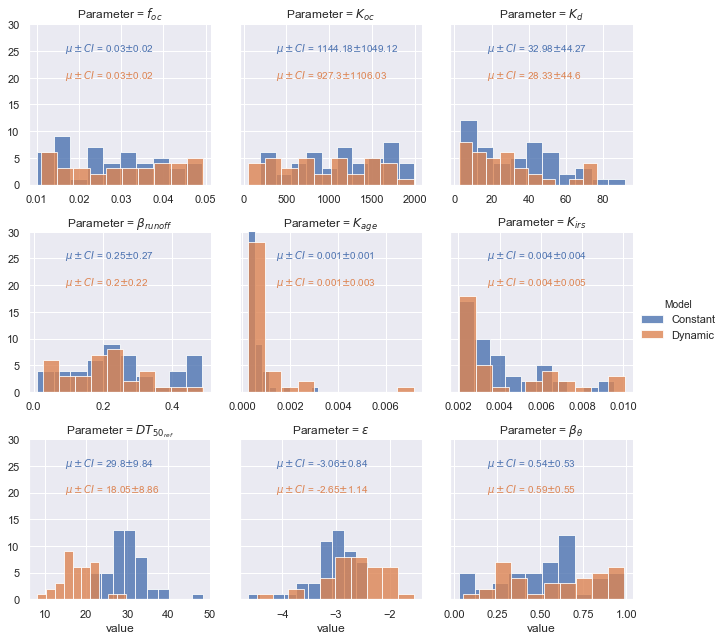

In [20]:
g = sns.FacetGrid(ps_blk, col="Parameter", hue="Model", col_wrap=3, sharex=False)
g = g.map(plt.hist, "value", alpha=.8).add_legend()

counter = 0
round_digs = 2
for ax in g.axes.flat:
    ax.set_ylim(0,30.)
    if counter == 4 or counter == 5:
        round_digs = 3
    else:
        round_digs = 2
    x_min = ax.get_xlim()[0] + (ax.get_xlim()[1]-ax.get_xlim()[0])*0.2
    ax.annotate('$\mu \pm CI$ = '+str(round(means_fix[counter], round_digs)) + 
                 '$\pm$' + str(round(stds_fix[counter],round_digs)), xy=(x_min, 25.), # 1.2 
                     xycoords='data', color="C0")
    
    ax.annotate('$\mu \pm CI$ = '+str(round(means_var[counter], round_digs)) + 
                 '$\pm$' + str(round(stds_var[counter],round_digs)), xy=(x_min, 20.), # 1.2 
                     xycoords='data', color="C1")
    counter += 1

## Pesticides
### WIC vs NIC

In [21]:
gen1x = dfs.loc[(dfs['Gen'] == 'Gen10') & (dfs['Model']=="var")]
blk_c = gen1x.loc[(gen1x['KGE-CONC-blk'] > .545) & (gen1x['KGE-d13C-blk'] >  -2) & (gen1x['KGE-Q_out'] >  0.545)]
blk_c['Type'] = "NIC"
blk_b = gen1x.loc[(gen1x['KGE-CONC-blk'] > .545) & (gen1x['KGE-d13C-blk'] >  .85) & (gen1x['KGE-Q_out'] >  0.545)]
blk_b['Type'] = "WIC"

In [22]:
# Sample the NIC df
from numpy import random

nic = []
for i in range(len(blk_b)):
    row = random.randint(0,len(blk_b))
    nic.append(blk_c[row:row+1])

blk_rand = pd.concat(nic) 

In [23]:
blk_all = pd.concat([blk_rand, blk_b])
ps_blk = pd.melt(blk_all, 
                 id_vars=['Gen',  'Model', "Type",
                          'KGE-CONC-tra', 'KGE-d13C-tra',
                          'KGE-CONC-blk', 'KGE-d13C-blk',
                          'KGE-CONC-det', 'KGE-d13C-det',
                          'KGE-Q_out'
                         ],
             value_vars=['f_oc',
                         'k_oc',
                         'k_d',
                         'beta_runoff',
                         'dt_50_aged',
                         'dt_50_ab',
                         'dt_50_ref',
                         'epsilon_iso',
                         'beta_moisture'
                         ])

In [24]:
print(len(blk_rand), len(blk_b))

(23, 23)


In [25]:
params = [
    'f_oc',
    'k_oc',
    'k_d',
    'beta_runoff',
    'dt_50_aged', # converted to rate k_age = ln(2)/dt_50_aged
    'dt_50_ab', # converted to rate k_irs = ln(2)/dt_50_ab
    'dt_50_ref',
    'epsilon_iso',
    'beta_moisture']

means_var = []
stds_var = []

means_fix = []
stds_fix = []

for e in params:
    means_var.append(ps_blk.loc[(ps_blk['variable'] == e) & (ps_blk['Type']=="WIC") ].mean()['value'])
    stds_var.append(ps_blk.loc[(ps_blk['variable'] == e) & (ps_blk['Type']=="WIC")].std()['value']*2)
    means_fix.append(ps_blk.loc[(ps_blk['variable'] == e) & (ps_blk['Type']=="NIC") ].mean()['value'])
    stds_fix.append(ps_blk.loc[(ps_blk['variable'] == e) & (ps_blk['Type']=="NIC")].std()['value']*2)

In [26]:
bounds_v15 =[[0.01, 0.05],  # f_oc,
              [0.3, 2000],  # k_oc, max Kd = 100
             [0.003, 100], # boundaries Kd
              [0.01, 0.5],  # beta_runoff
              [round(np.log(2)/3000.0,4), round(np.log(2)/10.0, 4)],  # age_rate
              [round(np.log(2)/350.0,4), round(np.log(2)/65.0,4)],  # dt_50_ab
              [5.0, 65.0],  # dt_50_ref
              [-0.3, -5.],  # epsilon (in absolute, convert to negative!!)
              [0.01, 1.0]]  # beta_moisture

In [27]:
k_age = (round(np.log(2)/3000.0,4), round(np.log(2)/10.0, 4))
k_irs = (round(np.log(2)/350.0,4), round(np.log(2)/65.0,4))
print(k_age, k_irs)

((0.0002, 0.0693), (0.002, 0.0107))


In [28]:
brackets_var = []
for i in range(len(means_var)):
    if i == 7:
        brackets_var.append((min(round(means_var[i]-stds_var[i],3), bounds_v15[i][0]), 
                     max(round(means_var[i]+stds_var[i],3), bounds_v15[i][1])))
    else:
        brackets_var.append((max(round(means_var[i]-stds_var[i],3), bounds_v15[i][0]), 
                         min(round(means_var[i]+stds_var[i],3), bounds_v15[i][1])))
brackets_var

[(0.01, 0.05),
 (0.3, 2000),
 (0.003, 76.71),
 (0.01, 0.378),
 (0.0002, 0.004),
 (0.002, 0.01),
 (9.279, 26.845),
 (-3.946, -1.469),
 (0.01, 1.0)]

In [29]:
# Rename variables
ps_blk.loc[ps_blk['variable'] == 'f_oc', 'Parameter'] = '$f_{oc}$'
ps_blk.loc[ps_blk['variable'] == 'k_oc', 'Parameter'] = '$K_{oc}$'
ps_blk.loc[ps_blk['variable'] == 'k_d', 'Parameter'] = '$K_d$'
ps_blk.loc[ps_blk['variable'] == 'beta_runoff', 'Parameter'] = '$\\beta_{runoff}$'
ps_blk.loc[ps_blk['variable'] == 'dt_50_aged', 'Parameter'] = '$K_{age}$'
ps_blk.loc[ps_blk['variable'] == 'dt_50_ab', 'Parameter'] = '$K_{irs}$'
ps_blk.loc[ps_blk['variable'] == 'dt_50_ref', 'Parameter'] = '$DT_{50_{ref}}$'
ps_blk.loc[ps_blk['variable'] == 'epsilon_iso', 'Parameter'] = '$\epsilon$'
ps_blk.loc[ps_blk['variable'] == 'beta_moisture', 'Parameter'] = '$\\beta_{\\theta}$'

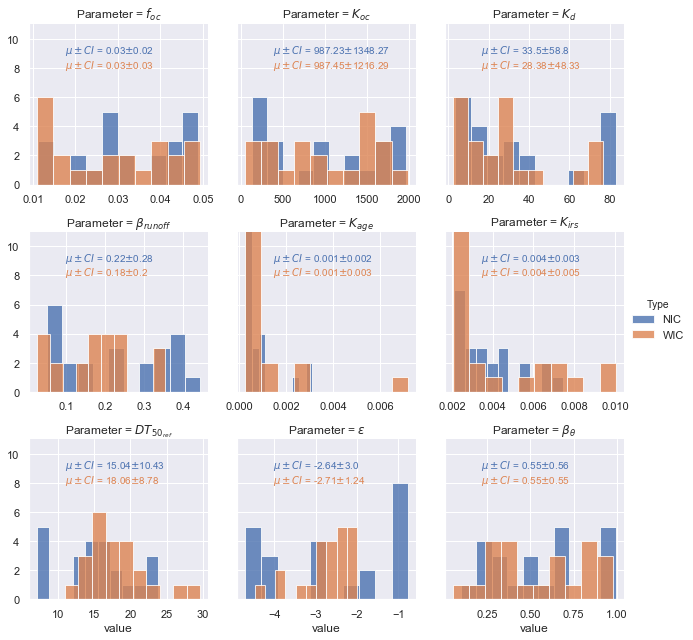

In [30]:
g = sns.FacetGrid(ps_blk, col="Parameter", hue="Type", col_wrap=3, sharex=False)
g = g.map(plt.hist, "value", alpha=.8).add_legend()

counter = 0
round_digs = 2
y_marker = 9.
for ax in g.axes.flat:
    ax.set_ylim(0,y_marker+2)
    if counter == 4 or counter == 5:
        round_digs = 3
    else:
        round_digs = 2
    x_min = ax.get_xlim()[0] + (ax.get_xlim()[1]-ax.get_xlim()[0])*0.2
    ax.annotate('$\mu \pm CI$ = '+str(round(means_fix[counter], round_digs)) + 
                 '$\pm$' + str(round(stds_fix[counter],round_digs)), xy=(x_min, y_marker), # 1.2 
                     xycoords='data', color="C0")
    
    ax.annotate('$\mu \pm CI$ = '+str(round(means_var[counter], round_digs)) + 
                 '$\pm$' + str(round(stds_var[counter],round_digs)), xy=(x_min, y_marker-1), # 1.2 
                     xycoords='data', color="C1")
    counter += 1